In [0]:
from google.colab import drive
drive.mount("/content/drive/")

In [29]:
from scipy.io import loadmat
from scipy.special import softmax

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn.functional as F

import time
import os
import copy


import cv2
from PIL import Image
import albumentations 
from albumentations import torch as AT
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
 
import warnings
warnings.filterwarnings('once')


plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

cuda:0
Tesla T4


In [39]:
import cv2
cv2.__version__

'3.4.3'

# Working with data

Firstly, I'm loading all the data necessary for training form [here](https://ai.stanford.edu/~jkrause/cars/car_dataset.html)
Here's 2 sets: trainig and testing and the labels along with bounding boxes providet in .mat format. I'm using while training set for training a model and whole test set (with labels) as validation set


In [0]:
#Reading all the .mat files
train_annos = loadmat('/content/drive/My Drive/devkit/cars_train_annos.mat')
test_annos = loadmat('/content/drive/My Drive/devkit/cars_test_annos.mat')
labels = loadmat('/content/drive/My Drive/devkit/cars_meta.mat')
test_annos_with_labels = loadmat('/content/drive/My Drive/cars_test_annos_withlabels.mat')

#Write all the labels as Cars models in separate list
labels = labels['class_names'][0]

In [0]:
df = pd.DataFrame(labels)
df[0] = df[0].apply(lambda x: x[0])
df.columns = ['Cars Model']

In [0]:
#Data cleaning
data_train = [[row.flat[0] for row in line] for line in train_annos["annotations"][0]]
columns_train = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2", "class", "fname"]
df_train = pd.DataFrame(data_train, columns=columns_train)
df_train['class'] = df_train['class']-1 #we need to make all the lables starting with 0, as putorch requires so.

data_test = [[row.flat[0] for row in line] for line in test_annos_with_labels["annotations"][0]]
columns_test = ["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2","class","fname"]
df_test = pd.DataFrame(data_test, columns=columns_test)
df_test['class'] = df_test['class']-1

Next, I create my own class to load images and labels directly to PyTorch Dataloader without separating all the images by class folders

In [0]:
class CarsDataset(Dataset):
    def __init__(self, datafolder, df=None, transform = transforms.Compose([transforms.ToTensor()])):
        
        self.datafolder = datafolder
        self.labels = df['class'].values
        self.image_fname = df['fname'].values
        self.bboxes = df[["bbox_x1", "bbox_y1", "bbox_x2", "bbox_y2"]].values
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform


    def __len__(self):
        return len(self.image_files_list)
    
    def crop_bbox(self,bbox,img_fname):
        """ Method cropps image by provided in .mat file bounding boxes
        """
        image = cv2.imread(img_fname)
        l1, l0,_ = image.shape
        
        b0 = bbox[2] - bbox[0]
        b1 = bbox[3] - bbox[1]
        x0n,x1n = max(int(bbox[0] - b0*0.05),0), min(int(bbox[2] + b0*0.05),l0-1)
        y0n,y1n = max(int(bbox[1] - b1*0.05),0), min(int(bbox[3] + b1*0.05),l1-1)
        
        image = image[y0n:y1n,x0n:x1n]
        return  image
    
    def __getitem__(self, idx):
        
        img_name = os.path.join(self.datafolder, self.image_fname[idx])
        label = self.labels[idx]
        image = self.crop_bbox(self.bboxes[idx], img_name)
        
        
        # By default OpenCV uses BGR color space for color images,
        # so we need to convert the image to RGB color space.
        #Uncomment next 5 rows for training and comment last 3
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         if self.transform:
#             augmented = self.transform(image=image)
#             image = augmented['image']

#             return image, label
        image = Image. fromarray(image).convert('RGB')
        image = self.transform(image)
        return image, label

Next part is image transformations and loading them to Dataloader. For image transformation I'm using 'albumentations' library. The library performs a diverse set of augmentations for the classification, detection, and segmentation tasks. Some unsual transforms:


*   ShiftScaleRotate - Randomly apply affine transforms: translate, scale and rotate the input
*   JpegCompression -  Decrease Jpeg compression of an image
*   HueSaturationValue - Randomly change hue, saturation and value of the input image





In [0]:
#Set transforms for train and val sets
data_transforms = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.HorizontalFlip(),
    albumentations.RandomBrightnessContrast(),
    albumentations.ShiftScaleRotate(rotate_limit=15, scale_limit=0.10),
    albumentations.JpegCompression(80),
    albumentations.HueSaturationValue(),
    albumentations.Normalize(),
    AT.ToTensor()
    ])
data_transforms_test = albumentations.Compose([
    albumentations.Resize(400, 400),
    albumentations.Normalize(),
    AT.ToTensor()
    ])

#Create Datsets using previously created class
train_set = CarsDataset(datafolder='/content/drive/My Drive/cars_train', df=df_train, transform=data_transforms)
test_set = CarsDataset(datafolder='/content/drive/My Drive/cars_test',df=df_test, transform=data_transforms_test)

train_sampler = torch.utils.data.SubsetRandomSampler(list(range(len(os.listdir('/content/drive/My Drive/cars_train')))))

#Using small batch size due to big images size, as I'm training on free GPU with Google Colab
batch_size = 8
num_workers = 2

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)

dataset_sizes = {'train': len(train_set), 'val':len(test_set)}

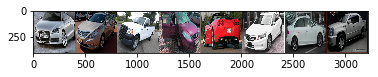

In [19]:
def imshow(inp):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# Training and validation

In [0]:
#Define metrics for classification
def performance_metrics(true,pred):
    
    precision = metrics.precision_score(true,pred,average='macro', labels=np.unique(pred))
    recall = metrics.recall_score(true,pred,average='macro', labels=np.unique(pred))
    f1_score = metrics.f1_score(true,pred,average='macro', labels=np.unique(pred))
    
    return [precision, recall, f1_score]
    

    

def train_model(model, criterion, optimizer, scheduler,model_fname, num_epochs=25 ):
    
    time_start = time.time()
    
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_acc = 0.0
    
    loss_list_val = []
    loss_list_train = []
    acc_list_val = []
    acc_list_train = []
        
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('='*85)
        
        for phase in ['train', 'val']:
            
            if phase=='train':
                scheduler.step(epoch_acc)
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = test_loader
                
            running_loss = 0.0
            running_corrects = 0
            
            metrics_list = []
            precision, recall, f1_score = 0.0, 0.0, 0.0
            
            #Iterate over the dataloader
            
            for inputs, classes in loader:
                inputs = inputs.to(device)
                classes = classes.to(device)
                                
                optimizer.zero_grad()
                
                #forward propagation
                with torch.set_grad_enabled(phase=='train'):
                    
                    outputs  = model(inputs)
                    _, preds = torch.max(outputs, 1)   
                    loss = criterion(outputs, classes)
                    
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                
                #Calculate statistics
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==classes.data)
               
                metrics_list = performance_metrics(classes.cpu(), preds.cpu())
                precision += metrics_list[0]
                recall += metrics_list[1]
                f1_score += metrics_list[2]
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'val':
                loss_list_val.append(epoch_loss)
                acc_list_val.append(epoch_acc)
            else:
                loss_list_train.append(epoch_loss)
                acc_list_train.append(epoch_acc)
           
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            print('{} Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1_Score: {:.4f}'
                  .format(phase, epoch_loss, epoch_acc, precision/len(loader), recall/len(loader), f1_score/len(loader)))
            
        print()
        
    time_elapsed = time.time() - time_start
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    path = F"/content/drive/My Drive/{model_fname}" 
    torch.save(model.state_dict(), path)
    
    return  loss_list_train, loss_list_val, acc_list_train, acc_list_val
 

I decided to use Transfer Learning for provided dataset e.x I worked with different variantions of different models(resnet, densenet, vgg, inception), but the best result was with resnextt101, here I'm also using ReduceLROnPlateau, SGD optimizer and CrossEntripy loss as loss function. This combination allowed me to reach 94.7% accuracy on the training set.

In [21]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')

model_ft = models.resnext101_32x8d(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 196)
# model_ft.aux_logits = False

# model_ft = models.densenet121(pretrained=True)
# model.classifier = nn.Sequential(nn.Linear(1024,NUM_CLASSES),
#                                  nn.Sigmoid())  
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='max', patience=2, threshold = 0.9)

loss_list_train, loss_list_val, acc_list_train, acc_list_val = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,'res152.pth',
                           num_epochs=15)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 356082095/356082095 [00:27<00:00, 12801617.18it/s]


Epoch 0/14


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


train Loss: 4.3302 Accuracy: 0.1008 Precision: 0.1070 Recall: 0.1134 F1_Score: 0.1085
val Loss: 2.6286 Accuracy: 0.3514 Precision: 0.3638 Recall: 0.3733 F1_Score: 0.3663

Epoch 1/14
train Loss: 2.2462 Accuracy: 0.5033 Precision: 0.5051 Recall: 0.5045 F1_Score: 0.5041
val Loss: 1.0209 Accuracy: 0.7586 Precision: 0.7599 Recall: 0.7626 F1_Score: 0.7603

Epoch 2/14
train Loss: 1.0407 Accuracy: 0.7953 Precision: 0.7947 Recall: 0.7935 F1_Score: 0.7935
val Loss: 0.4665 Accuracy: 0.8860 Precision: 0.8867 Recall: 0.8879 F1_Score: 0.8868

Epoch 3/14
train Loss: 0.5386 Accuracy: 0.8986 Precision: 0.8982 Recall: 0.8956 F1_Score: 0.8963
val Loss: 0.3336 Accuracy: 0.9096 Precision: 0.9099 Recall: 0.9105 F1_Score: 0.9098

Epoch 4/14
train Loss: 0.3052 Accuracy: 0.9413 Precision: 0.9411 Recall: 0.9400 F1_Score: 0.9403
val Loss: 0.2698 Accuracy: 0.9238 Precision: 0.9241 Recall: 0.9246 F1_Score: 0.9240

Epoch 5/14
train Loss: 0.1728 Accuracy: 0.9740 Precision: 0.9737 Recall: 0.9734 F1_Score: 0.9734
val 

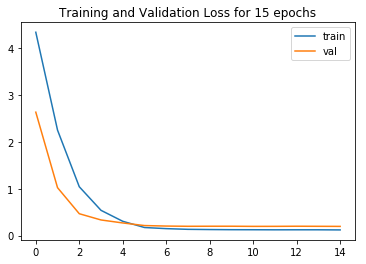

In [22]:
plt.plot(loss_list_train, label='train')
plt.plot(loss_list_val, label='val')
plt.title('Training and Validation Loss for 15 epochs')
plt.legend()
plt.show()

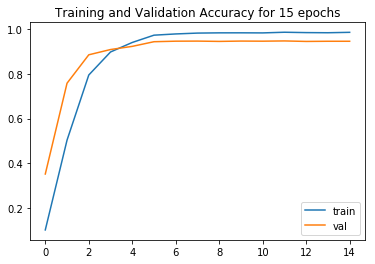

In [23]:
plt.plot(acc_list_train, label='train')
plt.plot(acc_list_val, label='val')
plt.title('Training and Validation Accuracy for 15 epochs')
plt.legend()
plt.show()

In [26]:
data_transforms_test = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

df = pd.read_csv('/content/drive/My Drive/df_test.csv')
df['class'] = df['class']-1
test_set = CarsDataset(datafolder='/content/drive/My Drive/test_test',df=df, transform=data_transforms_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=num_workers)


def test_set_accuracy(model, testloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the model on the test images: %d %%' % (
        100 * correct / total))
    


def load_model(model_file):
    model_ft = models.resnext50_32x4d(pretrained=True) 
    model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 196)
    checkpoint = torch.load(model_file)
    model_ft.load_state_dict(checkpoint)
    return model_ft
    
    
model=load_model(f'/content/drive/My Drive/resnext50_93.4.pth')
model.eval()

test_set_accuracy(model,test_loader )

Accuracy of the model on the test images: 100 %


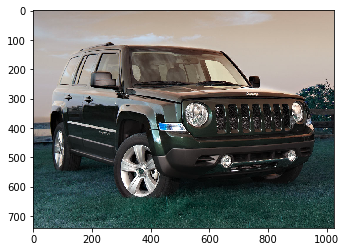

Class: J , confidence: 95.91%
Class: L , confidence: 1.49%
Class: J , confidence: 0.49%
Class: J , confidence: 0.48%
Class: J , confidence: 0.32%


tensor([144])

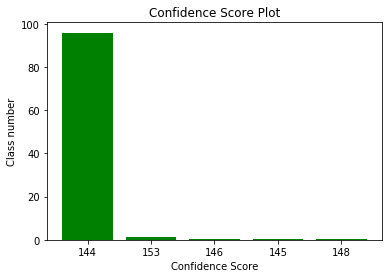

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def predict_one_image(model,img_fname,device, transforms = None):

    img = cv2.imread(img_fname)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    image = Image. open(img_fname).convert('RGB')
    image_tr= data_transforms_test(image)
    data = image_tr.expand(1,-1,-1,-1)

    probs = nn.Softmax(dim = 1)
    output = model(data)
    output = probs(output)
    _, predicted = torch.max(output.data, 1)
    
    img_plot(img)
    prediction_bar(output)
    
    return predicted

def prediction_bar(output):
    
    output = output.detach().numpy()
    pred_labels = output.argsort()[0]
    pred_labels = np.flip(pred_labels[-1*len(pred_labels):])
    
    prediction, label = [], []
    
    for i in pred_labels[:5]:
        prediction.append(float(output[:,i]*100))
        label.append(str(i))
        
    for i in pred_labels[:5]:
        print('Class: {} , confidence: {:.2f}%'.format(labels[int(i)][0],float(output[:,i])*100))
        
    plt.bar(label,prediction, color='green')
    plt.title("Confidence Score Plot")
    plt.xlabel("Confidence Score")
    plt.ylabel("Class number")
    
    return None
 
def img_plot(image):
    
    plt.imshow(image)
    plt.show()

image_name = '/content/drive/My Drive/cars_test/00003.jpg'
predict_one_image(model,image_name, device, transforms = data_transforms_test)